In [4]:
from manim import *
import jupyter_capture_output

video_scene = f" -v WARNING --disable_caching cf_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cf_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [43]:
main_color = BLACK


class IncomingSigmal(Mobject):
    def __init__(self, position, height, width, **kwargs):
        super().__init__(**kwargs)

        rectangle = Rectangle(height = height, width = width, stroke_width = 2, color = main_color).move_to(position)
        separator = Line(start = position - np.array([width/2, 0, 0]), end = position + np.array([width/2, 0, 0]), stroke_width = 1, color = main_color)
        self.add(rectangle, separator)


    def get_signal(self, omega_xyc):
        self.omega_x = omega_xyc[0]
        self.omega_y = omega_xyc[1]
        self.omega_c = omega_xyc[2]


    def get_ft_signal(self, omega_xyc):
        self.omega_x = omega_xyc[0]
        self.omega_y = omega_xyc[1]
        self.omega_c = omega_xyc[2]
        

class FTransformedImage(Mobject):
    def __init__(self, position, size, **kwargs):
        super().__init__(**kwargs)
        self.grid_center = position
        self.grid_sidelength = size
        self.grid_pixels = 128
        self.grid_node_dist = self.grid_sidelength / (self.grid_pixels + 1)

        # x-axis
        self.x_ax = NumberLine(
            x_range = [128, 256, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16
            ).set_color(RED).move_to(position - np.array([0, self.grid_sidelength/2+0.5, 0]))

        # y-axis
        self.y_ax = NumberLine(
            x_range = [256, 384, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16, rotation = PI/2, label_direction = LEFT
            ).set_color(BLUE).move_to(position - np.array([self.grid_sidelength/2+0.5, 0, 0]))

        # square with text
        square = Square(side_length = self.grid_sidelength, stroke_width = 2, stroke_color = main_color, **kwargs).move_to(np.array([self.x_ax.n2p(192)[0], self.y_ax.n2p(320)[1], 0]))
        square_text_head = Tex(r"Originales Bild", font_size = 32, color = main_color).next_to(square, 0.5*UP)
        self.add(self.x_ax, self.y_ax, square)


    # function to create a pixel for a given tupel of frequencies (omega_x, omega_y, omega_c)
    def get_pixel(self, omega_xyc):
        omega_x = omega_xyc[0] + self.grid_node_dist/2
        omega_y = omega_xyc[1] + self.grid_node_dist/2
        omega_c = omega_xyc[2]

        node_position = np.array([self.x_ax.n2p(omega_x)[0], self.y_ax.n2p(omega_y)[1], 0])
        return Square(side_length = self.grid_node_dist, color = GREY).move_to(node_position)


Output saved by creating file at animations/christmas_fourier/christmas_fourier.mp4.


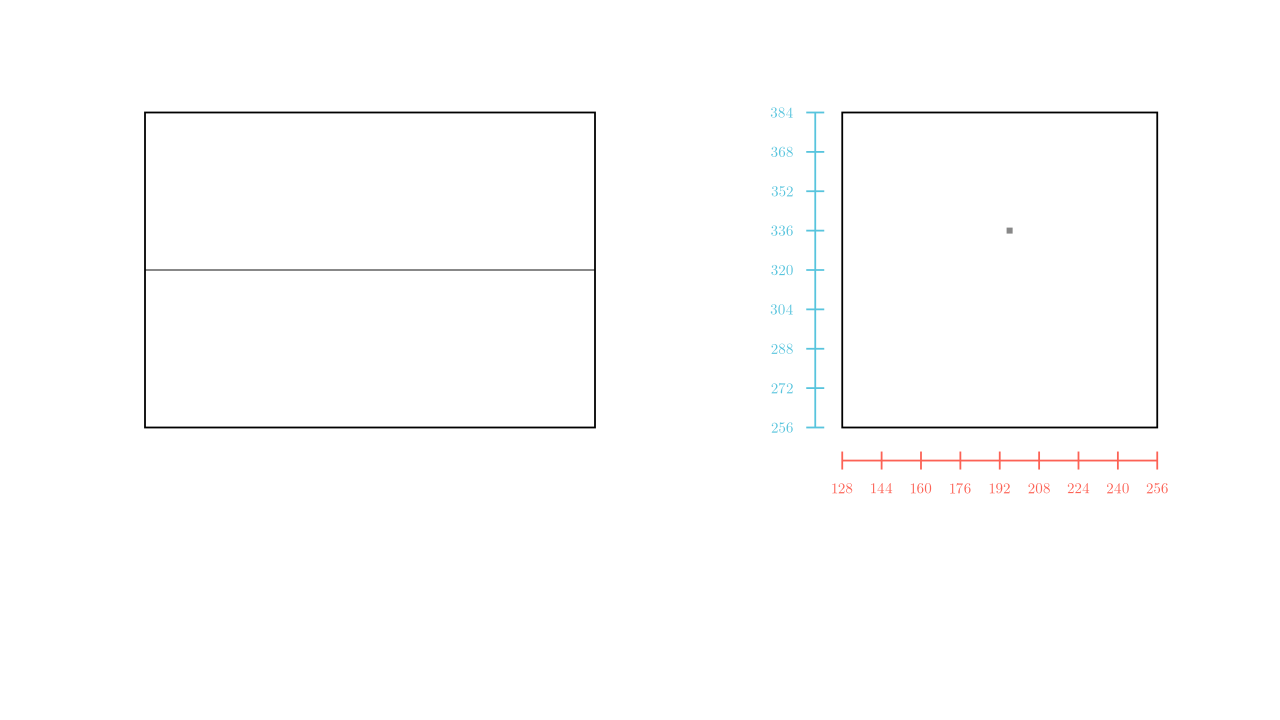

In [44]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier.mp4"
%%manim -qm --fps 20 $video_scene


class cf_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        image = FTransformedImage(position = np.array([4, 1, 0]), size = 3.5)
        self.add(image)

        sq = image.get_pixel((196, 336, 0))
        self.add(sq)

        signal = IncomingSigmal(position = (-3, 1, 0), height = 3.5, width = 5)
        self.add(signal)